# Getting Started with FLORIS V3

This notebook is designed to step through the basic operations of FLORIS V3 and highlight what is new/changed from FLORIS V2.4

In [1]:
import copy
import time

import matplotlib.pyplot as plt
import numpy as np

from floris.tools import FlorisInterface
from floris.tools.visualization import visualize_cut_plane

## Input file

As in V2, a floris interface object is the main point of interaction with FLORIS.

Something that is new is that the input file is in YAML format to enable new syntax around mixed turbine farms and to cut down on errors related to many-nested brackets

In [2]:
# Initialize FLORIS with the given input file via FlorisInterface.
# For basic usage, FlorisInterface provides a simplified and expressive
# entry point to the simulation routines.
fi = FlorisInterface("inputs/gch.yaml")

## Reinitialize function

Similarly to V2, changes to the background flow and farm are put in place via a reinitialize function.  Another way to think of this function is that it changes the value of variables specified in the input yaml file

#### Change farm layout

In [3]:
# Design a 2x2 farm, units are m
X = np.array([0, 0, 800, 800])
Y = np.array([0, 400, 0, 400])
fi.reinitialize(layout=[X,Y])

#### Changing the wind direction and speed

This aspect is one of the major changes from V2 to V3.  

Previously, wind speeds and directions descrobed one condition.  Now they can describe one or multiple conditions, including an entire wind rose at once.  This enables the underlying vectorization which allows the computations to be handled at once, rather than wrapped in a loop.

Some aspects of this specification are still under consideration, but in current form, unless explicitly specified to represent a time series, a vector of wind directions and wind speeds will be "expanded" such that each combination of wind direction and wind speed is computed.

In [4]:
# One wind direction and one speed
fi.reinitialize(wind_directions=[270], wind_speeds=[8.])

# Two wind directions and one speed (Two combinations)s
fi.reinitialize(wind_directions=[270, 280], wind_speeds=[8.])

# Two wind directions and two speeds (Four combinations)
fi.reinitialize(wind_directions=[270, 280], wind_speeds=[8., 9.])

## Calculate Wake

Similar again to V2, there is a calculate_wake function.  In V3 this will calculate the velocities for every specified grid point, and for every specified wind speed and wind direction.  If not doing visualization, grid points will be on the turbine rotors

In [5]:
fi.calculate_wake()

#### Applying yaw angles

Yaw angles are applied to turbines in the calculate wake function.  Some important things to note when using the new framwork

**yaw_angles is a matrix** -- You must provide yaw angles in a matrix with 
* wind directions
* wind speeds
* turbines

**unlike variables passed in reinitialize, yaw angles applied to calculate wake are not remembered between calls**

In [6]:
# Matrix of zero yaw angles
num_wd = 2
num_ws = 2
num_turbine = 4
yaw_angles_zero = np.zeros([num_wd, num_ws, num_turbine])
fi.calculate_wake(yaw_angles = yaw_angles_zero)
yaw_angles_zero

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [7]:
# Yaw the front row for all wind directions and all wind speeds
yaw_angles_yaw_front = np.zeros([num_wd, num_ws, num_turbine])
yaw_angles_yaw_front[:,:,:2] = 25
fi.calculate_wake(yaw_angles = yaw_angles_yaw_front)
yaw_angles_yaw_front

array([[[25., 25.,  0.,  0.],
        [25., 25.,  0.,  0.]],

       [[25., 25.,  0.,  0.],
        [25., 25.,  0.,  0.]]])

## Getting turbine power

The calculate wake function computes the velocity at each grid point on each turbine.  To then compute the power, you call the get_turbine_power() function

In [8]:
# Aligned
fi.calculate_wake(yaw_angles = yaw_angles_zero)
powers_aligned = fi.get_turbine_powers()/1000.

# Yawed
fi.calculate_wake(yaw_angles = yaw_angles_yaw_front)
powers_yawed = fi.get_turbine_powers()/1000.

The powers are returned in a matrix of the same dimensions as the yaw_angles matrix and by default in units W (the division by 1000 converting to kW in the above example code)

In [9]:
powers_aligned

array([[[1691.32648289, 1691.32648289,  592.65288889,  592.97819946],
        [2407.84258855, 2407.84258855,  861.30598083,  861.73203268]],

       [[1691.32648289, 1691.32648289, 1629.75508349, 1629.75457548],
        [2407.84258855, 2407.84258855, 2319.53233514, 2319.53161349]]])

In [10]:
# Can therefore use normal slice operations to get specific powers
print('Power of turbine 0 across wd/ws conditions for aligned case')
print(powers_aligned[:,:,0])
print('--')
print('Power of all turbines when wind direction = 280 and wind speed = 9')
print(powers_aligned[1,1,:])

Power of turbine 0 across wd/ws conditions for aligned case
[[1691.32648289 2407.84258855]
 [1691.32648289 2407.84258855]]
--
Power of all turbines when wind direction = 280 and wind speed = 9
[2407.84258855 2407.84258855 2319.53233514 2319.53161349]


In [11]:
# Can also use sum operations across dimensions

farm_power_aligned = np.sum(powers_aligned,2) # Some over turbine dimension
farm_power_yawed = np.sum(powers_yawed,2) # Some over turbine dimension

print('Farm power across wind directions and speeds')
print(farm_power_aligned)

# This specific matrix could have been obtained via the get_farm_power function
fi.calculate_wake(yaw_angles = yaw_angles_zero)
print(fi.get_farm_power()/1000.)

Farm power across wind directions and speeds
[[4568.28405413 6538.72319062]
 [6642.16262475 9454.74912574]]
[[4568.28405413 6538.72319062]
 [6642.16262475 9454.74912574]]


## On Grid Points

In FLORIS, grid points are the points in space where the wind conditions are calculated.  In a typical simulation, these are all located on a regular grid on each turbine rotor

The parameter **turbine_grid_points** specifies the number of rows and columns which define the turbine grid.  In the default yaml this value is 3, meaning there are 3x3 = 9 total grid points.  Wake steering codes currently require greater values greater than 1 in order to compute gradients.  However, it is likely 1x1 is suitable for non wind farm control applications, although retuning of some parameters could be warrented.

We can visualize the locations of the grid points in the current example using pyplot

xs has shape:  (2, 2, 4, 3, 3)  of 2 wd x 2 ws x 4 turbines x 3 x 3 grid points


(0.0, 150.0)

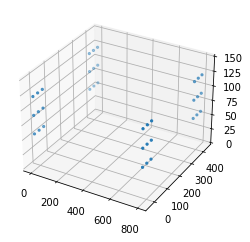

In [12]:
# Get the grid points
xs = fi.floris.grid.x
ys = fi.floris.grid.y
zs = fi.floris.grid.z

# Consider the shape
print('xs has shape: ',xs.shape, ' of 2 wd x 2 ws x 4 turbines x 3 x 3 grid points')

# Lets plot just one wd/ws conditions
xs = xs[0,0,:,:,:]
ys = ys[0,0,:,:,:]
zs = zs[0,0,:,:,:]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs, ys, zs, marker=".")
ax.set_zlim([0, 150])

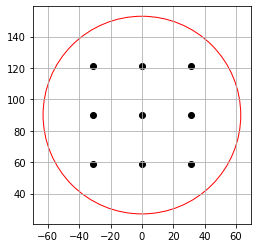

In [13]:
# Can further consider the points on just the 0th turbine
ys_turbine_0 = ys[0,:,:]
zs_turbine_0 = zs[0,:,:]

fig, ax = plt.subplots()
ax.scatter(ys_turbine_0, zs_turbine_0, color='k')

# Draw the rotor in the wind-direction rotated coordinate frame
circle = plt.Circle((np.mean(ys_turbine_0), fi.floris.turbine.hub_height), fi.floris.turbine.rotor_diameter / 2.0, color='r', fill=False)
ax.add_patch(circle)
ax.set_aspect('equal')
ax.grid(True)

## Visualization

Tools for visualizing the flow are similar to how they operated in V3 however there are important changes

First, because yaw angles are no longer remembered from previous calculate wake calls, it is important to pass in the yaw angles to the visualization function itself

Second, visualization does not accept multiple wind directions and wind speeds it is important to reinitialize if the original was using arrays of wind speeds and directions

In [14]:
# Choose one wind direction and one wind speed
fi.reinitialize(wind_directions = [280.], wind_speeds = [9.])
fi.calculate_wake()

# The yaw angles matrix must also be of only one wind speed and wind direction
# But still should have 3 dimensions
# Take just this slice and flatten
yaw_angles_zero_viz = np.zeros([1,1,num_turbine])
yaw_angles_yaw_front_viz = np.zeros([1, 1, num_turbine])
yaw_angles_yaw_front_viz[:,:,:2] = 25



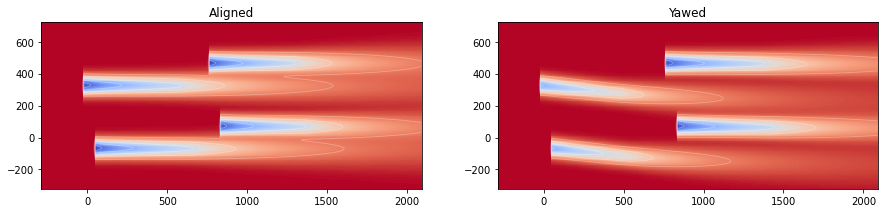

In [15]:
fig, axarr = plt.subplots(1,2,figsize=(15,5))

# Plot the aligned case
horizontal_plane = fi.calculate_horizontal_plane(yaw_angles=yaw_angles_zero_viz)
visualize_cut_plane(horizontal_plane, ax=axarr[0], title="Aligned")

# Plot the yawed case
horizontal_plane = fi.calculate_horizontal_plane(yaw_angles=yaw_angles_yaw_front_viz)
visualize_cut_plane(horizontal_plane, ax=axarr[1], title="Yawed")

Visualization makes a new grid of points on the plane to be visualized in addition to those on the rotor.  This is done within the calculate_horizontal_plane call.  The grid is however set back to how it was originally at the completion of the funcion as can be confirmed

xs has shape:  (1, 1, 4, 3, 3)  of 2 wd x 2 ws x 4 turbines x 3 x 3 grid points


(0.0, 150.0)

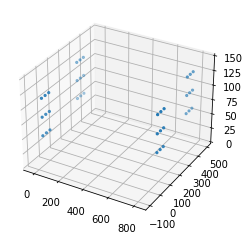

In [16]:
# Get the grid points
xs = fi.floris.grid.x
ys = fi.floris.grid.y
zs = fi.floris.grid.z

# Consider the shape
print('xs has shape: ',xs.shape, ' of 2 wd x 2 ws x 4 turbines x 3 x 3 grid points')

# Lets plot just one wd/ws conditions
xs = xs[0,0,:,:,:]
ys = ys[0,0,:,:,:]
zs = zs[0,0,:,:,:]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs, ys, zs, marker=".")
ax.set_zlim([0, 150])

## Calculating AEP

Calculating AEP in FLORIS V3 takes advantage of the new vectorized framework to substantially reduce the computation time with respect to V2.4

In these examples we demonstrate a simplied AEP calculation for a 25-turbine farm using several different modeling options.

We will make a simplifying assumption that every wind speed and direction is equally likely

In [106]:
wind_directions = np.arange(0.,360.,5.)
wind_speeds = np.arange(6.,25.,1.)


num_wind_directions = len(wind_directions)
num_wind_speeds = len(wind_speeds)
num_bins = num_wind_directions * num_wind_speeds
print('Calculating AEP for %d wind direction and speed combinations' % num_bins)

Calculating AEP for 1368 wind direction and speed combinations


In [114]:
# Set up a square 25 turbine layout
N = 5  # Number of turbines per row and per column
D = 126. 

X, Y = np.meshgrid(
    7.0 * D * np.arange(0, N, 1),
    7.0 * D * np.arange(0, N, 1),
)
X = X.flatten()
Y = Y.flatten()
print("Number of turbines = %d" % len(X))

Number of turbines = 25


In [115]:
# Define several models
fi_jensen = FlorisInterface("inputs/jensen.yaml")
fi_gch = FlorisInterface("inputs/gch.yaml")
fi_cc = FlorisInterface("inputs/cc.yaml")


In [116]:
# Assign the layouts, wind speeds and directions
fi_jensen.reinitialize(layout=(X,Y),wind_directions=wind_directions,wind_speeds=wind_speeds)
fi_gch.reinitialize(layout=(X,Y),wind_directions=wind_directions,wind_speeds=wind_speeds)
fi_cc.reinitialize(layout=(X,Y),wind_directions=wind_directions,wind_speeds=wind_speeds)

Calculate the AEP and use the jupyter time command to show computation time

In [117]:
%%time
fi_jensen.calculate_wake()
jensen_aep = fi_jensen.get_farm_power().sum() / num_bins  / 1E9 * 365 * 24

CPU times: user 3.25 s, sys: 1.21 s, total: 4.46 s
Wall time: 3.47 s


In [118]:
%%time
fi_gch.calculate_wake()
gch_aep = fi_gch.get_farm_power().sum() / num_bins  / 1E9 * 365 * 24

CPU times: user 5.33 s, sys: 1.37 s, total: 6.7 s
Wall time: 5.17 s


In [119]:
%%time
fi_cc.calculate_wake()
cc_aep = fi_cc.get_farm_power().sum() / num_bins  / 1E9 * 365 * 24

CPU times: user 7.31 s, sys: 1.23 s, total: 8.54 s
Wall time: 8.61 s


In [120]:
# Show the results
print('Jensen %.1f GWh' % jensen_aep)
print('GCH %.1f GWh' % gch_aep)
print('CC %.1f GWh' % cc_aep)

Jensen 883.9 GWh
GCH 884.4 GWh
CC 879.6 GWh
